We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add FTLE folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FTLE2D")

# add ActiveBarriers folder to current working path
sys.path.append(parent_directory+"/demos/ActiveBarriers")

# Overview

We illustrate the numerical implementation and the use of the active Finite Time Lyapunov Exponent ($ \mathrm{aFTLE} $) on 2-D homogeneous, isotropic turbulence. The active LCS diagnostic is applied to the two-dimensional and steady Lagrangian vorticity barrier equation. The notebook is structured as follows:

1. Import vorticity and velocity data stored in the folder 'data/Turbulence'. Make sure that all the necessary files are stored in the folder 'data/Turbulence'.
<br />
2. Define computational parameters and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. Lagrangian vorticity barriers from active Finite Time Lyapunov Exponent ($\mathrm{aFTLE}$):

   <br />
   
   * For 2D incompressible, uniform-density Navier–Stokes flows, the Lagrangian barrier equation for vorticity is an autonomous Hamiltonian system of the form:
    \begin{equation}
    \mathbf{x}_0'(s)= \dfrac{\nu}{t_1-t_0} \mathbf{J} \nabla \delta \mathbf{\omega (\mathbf{x}_0, t_0,t_1)},
    \label{eq: vorticity},
    \end{equation}
    
    Time 't' is just a fixed parameter and hence the system is autonomous and the integration is done with respect to a dummy time variable 's'. 's' can be arbitrarily large and the $\mathrm{aFTLE}$ is only limited by the spatial resolution and domain. It can thus potentially reveal finer and more resolved structures compared to the classic version of the $\mathrm{FTLE}$, which is fundamentally limited by the spatial and temporal domain of the available data.
    
    <br />
    
   * First we compute the trajectories over the time-interval [0, 25] over the selected domain. We then compute the right-hand-side of equation \ref{eq: vorticity} by interpolating $ \mathbf{J} \mathbf{\nabla_0 \overline{\omega (\mathbf{F_{t_0}^{t}(x_0)}, t)}} $, where $ \overline{(\ldots)} $ denotes a temporal average.
   
   <br />
   
   * We then apply the $ \mathrm{aFTLE} $ to the autonomous ODE from equation \ref{eq: vorticity} over different dummy time-intervals. We additionally compare the results with the classic $ \mathrm{FTLE} $-field.
   
 <br />
6. References

# Import data

We start by importing the turbulence-data from the files located in the folder 'data/Turbulence'.

In [2]:
# import scipy
import scipy.io

# import numpy
import numpy as np

# load vorticity data
turb_w = parent_directory + r'/data/Turbulence/turb_w'

omega = np.zeros((1024, 1024, 251))

# iterate over all files in folder 'turb_w' and load vorticity data
i = 0
for filename in sorted(os.listdir(turb_w)):
    if filename.endswith(".mat"):
        file_w = os.path.join(turb_w, filename)
        mat_turb_w = scipy.io.loadmat(file_w)
        omega[:,:,i] = mat_turb_w['w']
        i+=1

# load velocity data
turb_u = parent_directory + r'/data/Turbulence/turb_u'
      
# iterate over all files in folder 'turb_u' and load velocity data
i = 0
U = np.zeros((1024, 1024, 251))
V = np.zeros((1024, 1024, 251))
for filename in sorted(os.listdir(turb_u)):
    if filename.endswith(".mat"):
        file_u = os.path.join(turb_u, filename)
        mat_turb_u = scipy.io.loadmat(file_u)
        U[:,:,i] = mat_turb_u['u1']
        V[:,:,i] = mat_turb_u['u2']
        i+=1

# load x/y grid
X = scipy.io.loadmat(parent_directory + r'/data/Turbulence/grid.mat')['x']
Y = X.copy().transpose()

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# Number of cores for parallel computing
Ncores = 6

# time-interval over which data is defined. DO NOT CHANGE!!!
time_data = np.linspace(0, 50, 251, endpoint = True).reshape(1, -1)

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time
t0 = 0 # int

# Final time
tN = 25 # int

# time step-size
dt = .2 # float

# Time array
time = np.arange(t0, tN+dt, dt) # array (Nt, )

# length of time interval (in days)
lenT = tN-t0

# domain boundary
xmin = 3
xmax = 5
ymin = 1
ymax = 3

Nx = 300
Ny = 300

# specify domain over which to compute linear momentum barriers
x_domain = np.linspace(xmin, xmax, Nx)
y_domain = np.linspace(ymin, ymax, Ny)

# make sure that the spatio-temporal you defined are within the domain of the data
assert np.min(X) <= xmin <= np.max(X), " xmin must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(X) <= xmax <= np.max(X), " xmax must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(Y) <= ymin <= np.max(Y), " ymin must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(Y) <= ymax <= np.max(Y), " ymax must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(time_data) <= t0 <= np.max(time_data), " t0 must be between "+f'{np.min(time_data)} and {np.max(time_data)}'
assert np.min(time_data) <= tN <= np.max(time_data), " tN must be between "+f'{np.min(time_data)} and {np.max(time_data)}'

# grid-spacing
dx = x_domain[1]-x_domain[0]
dy = y_domain[1]-y_domain[0]

#compute meshgrid
X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# define dummy time interval
ds = 0.002
sN = 0.25 # Feel free to change this parameter as needed
s_dummy = np.arange(0, sN+ds, ds)

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # float between [1/100, 1/5]
aux_grid = [aux_grid_ratio*dx, aux_grid_ratio*dy] # list (2, )

# Interpolate velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default value is "cubic".

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

# Lagrangian vorticity barriers from active Finite Time Lyapunov Exponent ($\mathrm{aFTLE}$)

We visualize Lagrangian vorticity barriers by applying the $ \mathrm{FTLE} $-field to the trajectories of system \ref{eq: vorticity}. As soon as the $ \mathrm{FTLE} $-field is applied to an active vector field, such as vorticity, we refer to it as $ \mathrm{aFTLE} $ (active $ \mathrm{FTLE} $). We will subsequently compare the results with the classic version of the \mathrm{FTLE}-field.

## Compute trajectories

In [6]:
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to compute trajectories (=flow map)
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import package for parallel computing
from joblib import Parallel, delayed

# split x0, y0 into 'Ncores' (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def parallel_Fmap(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch])
    
    Fmap = integration_dFdt(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[0]
    
    return Fmap

In [7]:
# vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel()
y0 = Y_domain.ravel()

x0_batch = list(split(x0, Ncores))
y0_batch = list(split(y0, Ncores))

results = Parallel(n_jobs=Ncores, verbose = 50)(delayed(parallel_Fmap)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# extract aFTLE field from results of parallel computing
Fmap = results[0]

for res in results[1:]:
    Fmap = np.append(Fmap, res, axis = 2)
    
# reshape array from vectorized form to structured meshgrid
X0_gridded = x0.reshape((X_domain.shape[0], X_domain.shape[1]))
Y0_gridded = y0.reshape((X_domain.shape[0], X_domain.shape[1]))

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   53.9s
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:   53.9s remaining:  1.8min
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   54.1s remaining:   54.1s
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:   54.2s remaining:   27.1s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   54.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   54.4s finished


## Interpolate Lagrangian vorticity barrier field

We start by computing the interpolant for the Lagrangian vorticity barrier field. The interpolant is given by the right-hand-side of equation \ref{eq: vorticity}.

In [8]:
# Import interpolation function for Lagrangian vorticity barrier equation
from ipynb.fs.defs.LagrangianActiveVorticity import LagrangianActiveVorticity

# Interpolate RHS of vorticity barrier equation using cubic spatial interpolation
Interpolant_vorticity = LagrangianActiveVorticity(X_domain, Y_domain, X, Y, omega, Fmap, time, dt_data, aux_grid)

## Compute active FTLE

We now compute the active $ \mathrm{FTLE} $ for the Lagrangian vorticity barrier equations. First, we evaluate the active Cauchy-Green strain tensor from the gradient of the active flow map over the meshgrid. The active flow map is given by the solution of the autonomous ODE from equation \ref{eq: vorticity}. Finally, we apply the classic $ \mathrm{FTLE} $ to the active Cauchy-Green strain tensor.

In [9]:
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to compute finite time Lyapunov exponent (FTLE)
from ipynb.fs.defs.FTLE import _FTLE

# Import package for parallel computing
from joblib import Parallel, delayed

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def parallel_aFTLE(x0_batch, y0_batch, s_dummy, s):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch]) # array (2, Nx*Ny)

    # Compute gradient of flow map
    DF = gradient_flowmap(s_dummy, X0, X, Y, Interpolant_vorticity[0], Interpolant_vorticity[1], periodic, defined_domain, False, s_dummy.reshape(1,-1), aux_grid) # array (Nt, 2, 2, Nx*Ny)

    aFTLE = np.zeros((len(s), DF.shape[-1]))
    
    counter = 0
    for idx in np.searchsorted(s_dummy, s):
        
        # Extract gradient from s0 to si
        DF_s0_si = DF[idx,:, :, :] # array (Nt, 2, 2, Nx*Ny)
        
        for i in range(DF.shape[3]):
            
            # Compute active FTLE
            aFTLE[counter, i] = _FTLE(DF_s0_si[:,:,i], s_dummy[idx])
            
        counter += 1
    
    return aFTLE

In [10]:
# Define dummy time-intervals for computation of aFTLE
s1 = 0.05
s2 = 0.15
s3 = 0.25

s = [s1, s2, s3]

# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, )
x0 = X_domain.ravel() # array (Nx*Ny,)
y0 = Y_domain.ravel() # array (Nx*Ny,)

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny)

results = Parallel(n_jobs=Ncores, verbose = 50)(delayed(parallel_aFTLE)(x0_batch[i], y0_batch[i], s_dummy, s) for i in range(len(x0_batch)))

# Extract FTLE from results of parallel computing
aFTLE = results[0]

for res in results[1:]:
    aFTLE = np.append(aFTLE, res, axis = 1)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   27.1s
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:   29.9s remaining:   59.7s
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   32.0s remaining:   32.0s
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:   34.1s remaining:   17.1s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   37.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   37.7s finished


## Classic Finite-Time Lyapunov Exponent (FTLE)

Next, we compute the $ \mathrm{FTLE} $ over the meshgrid over the given time-interval.
We iterate over all initial conditions and first calculate the gradient of the flow map using an auxiliary grid. Subsequently, we compute the Cauchy Green strain tensor. From the maximum eigenvalue of the Cauchy-Green strain tensor we can then compute the $ \mathrm{FTLE} $. The iteration over the meshgrid is parallelized.

In [11]:
# split x0, y0 into 'Ncores' (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def parallel_FTLE(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch])

    # Compute gradient of flow map
    gradFmap = gradient_flowmap(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid) # shape (Nt, 2, 2, Nx*Ny)

    # extract gradient from t0 to tN
    gradFmap_t0_tN = gradFmap[-1,:, :, :] # shape (Nt, 2, 2, Nx*Ny)

    # compute FTLE
    FTLE = []
    for i in range(gradFmap_t0_tN.shape[2]):
            FTLE.append(_FTLE(gradFmap_t0_tN[:,:,i], lenT))
    return FTLE

In [12]:
# vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel()
y0 = Y_domain.ravel()

x0_batch = list(split(x0, Ncores))
y0_batch = list(split(y0, Ncores))

results = Parallel(n_jobs=Ncores, verbose = 50)(delayed(parallel_FTLE)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# extract FTLE field from results of parallel computing
FTLE = results[0]

for res in results[1:]:
    FTLE = np.append(FTLE, res)
    
# reshape array from vectorized form to structured meshgrid
FTLE = FTLE.reshape((X_domain.shape[0], X_domain.shape[1]))

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  2.6min remaining:  5.2min
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:  2.7min remaining:  2.7min
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:  2.8min remaining:  1.4min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  2.8min finished


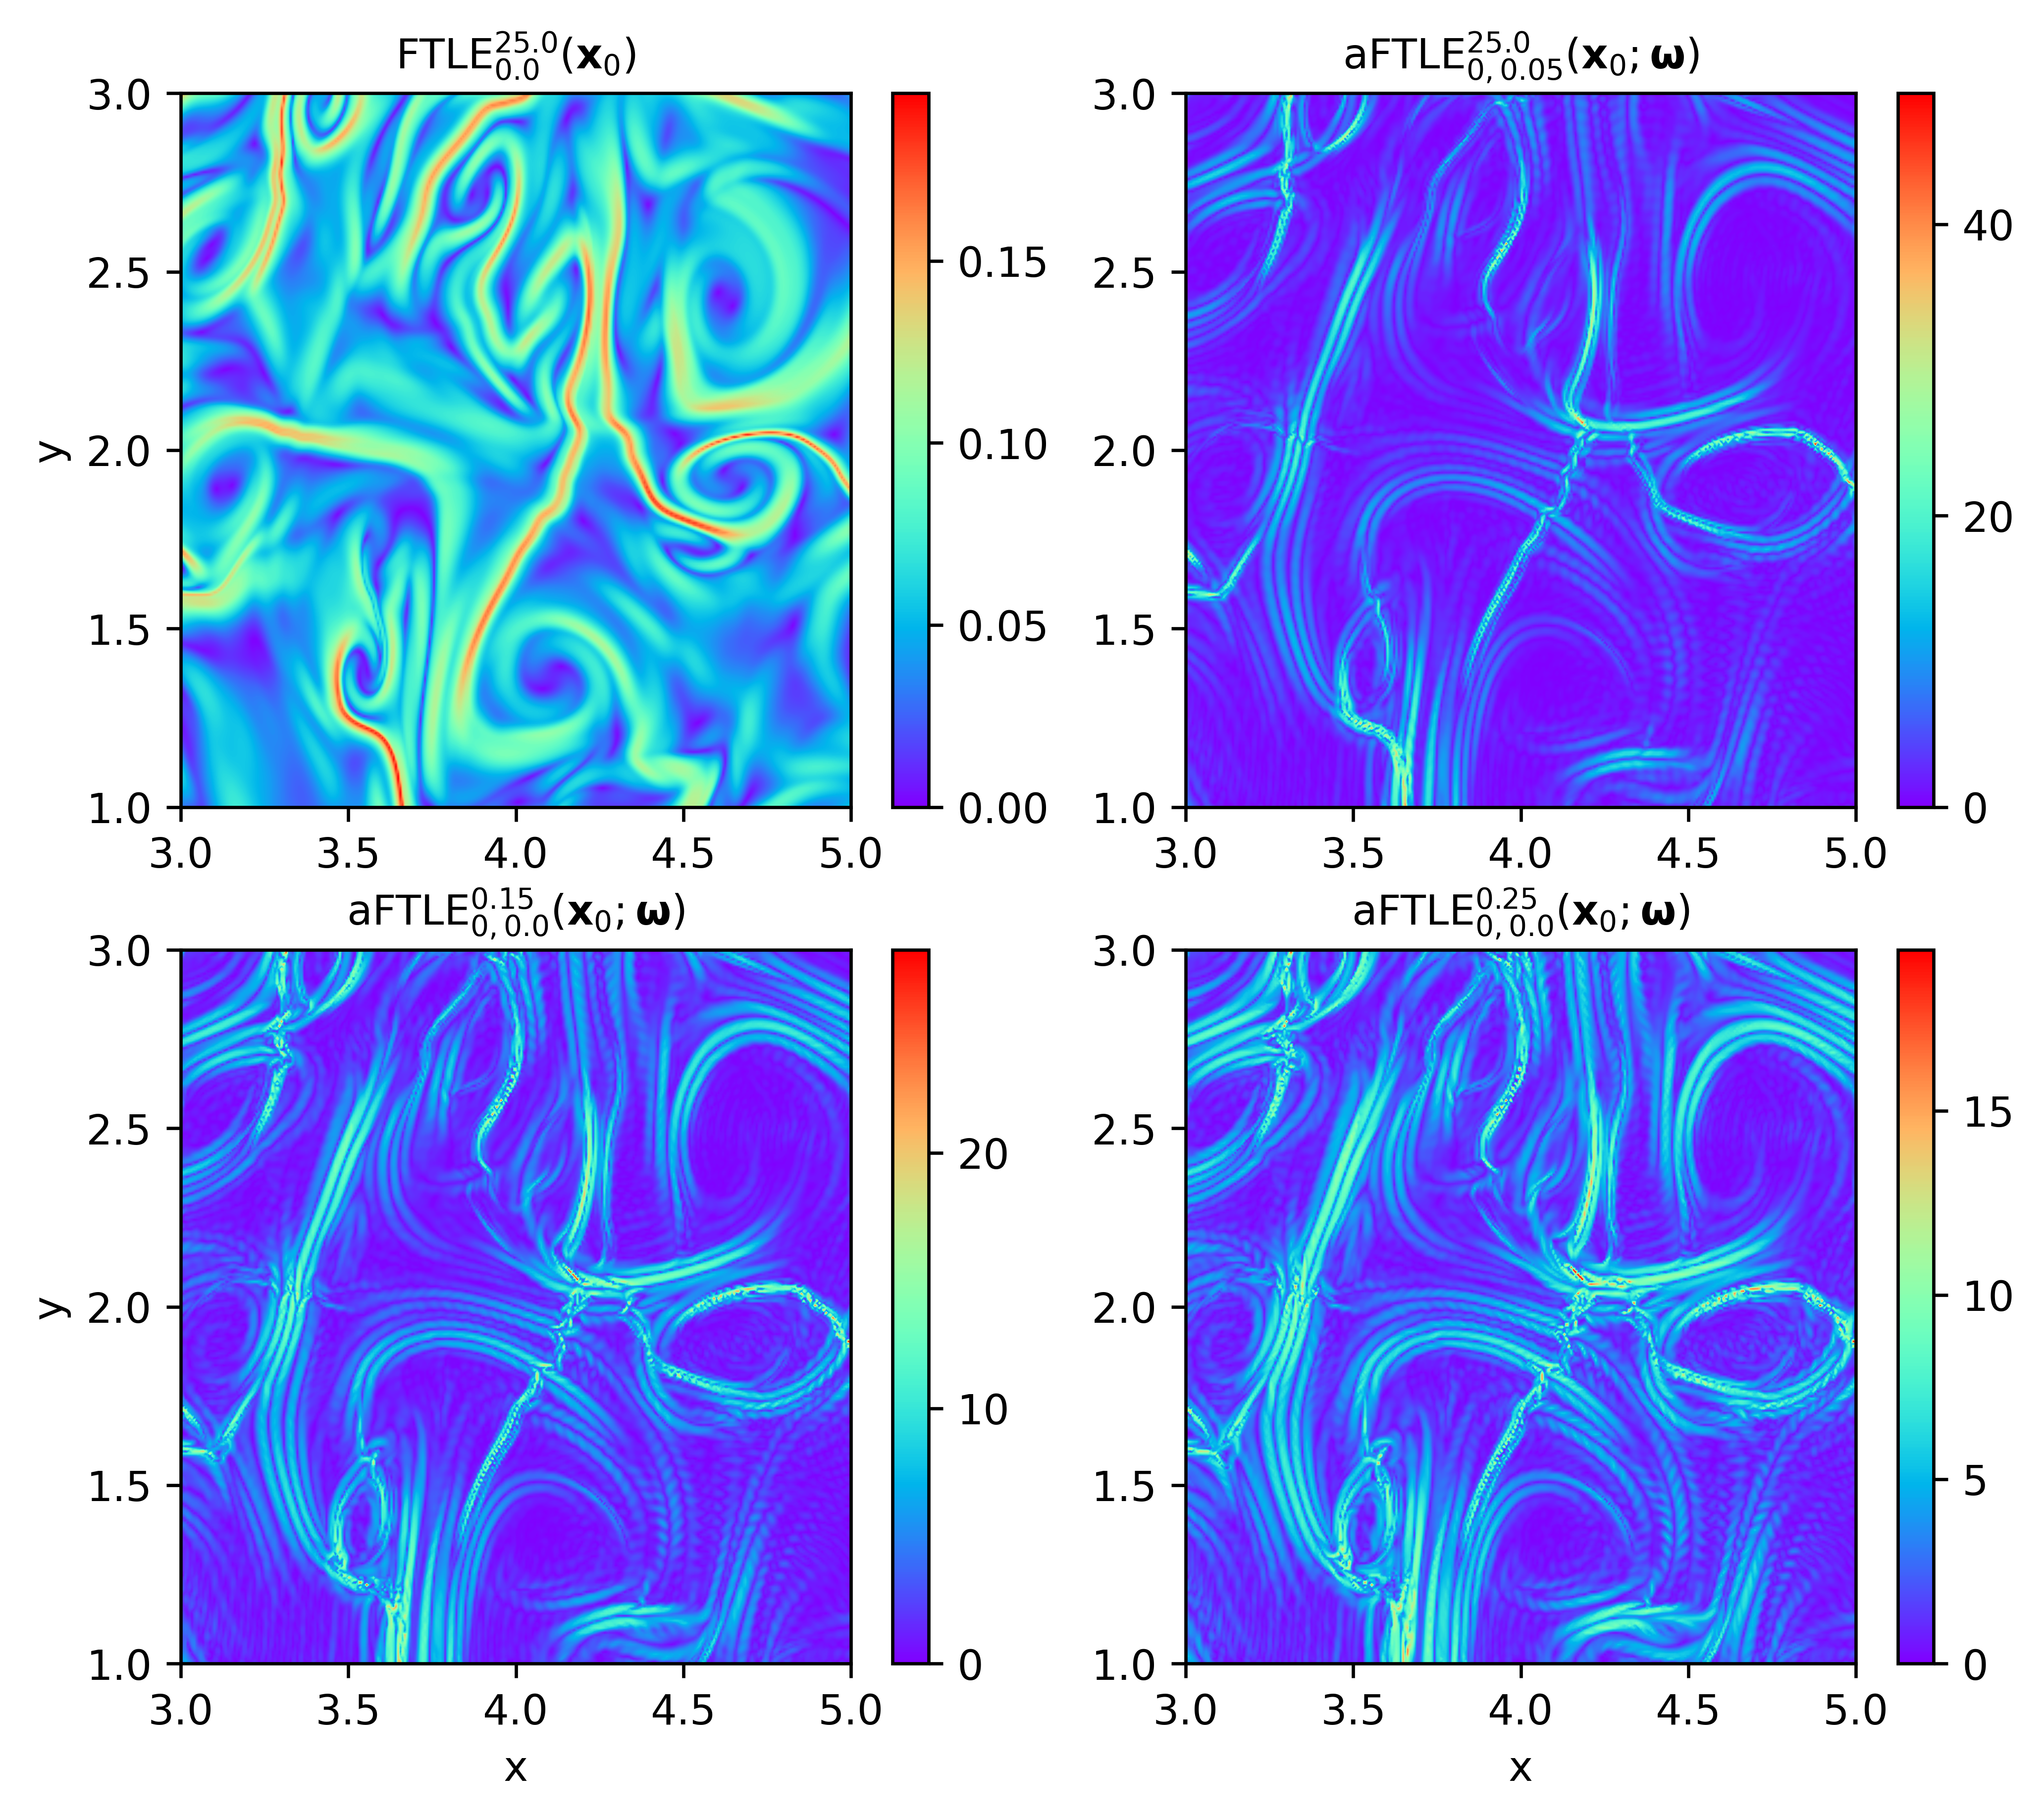

In [13]:
################################################ PLOT RESULTS ################################################

# Import plotting library
import matplotlib.pyplot as plt

# Figure/Axis
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, dpi = 600, figsize=(8, 7))

# Contourplot of classic FTLE over the time-interval [0,25] over meshgrid of initial conditions
cax = ax0.contourf(X_domain, Y_domain, FTLE, cmap = "rainbow", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax0, ticks = np.arange(0, 0.4, 0.05))

# Contourplot of aFTLE_0^0.05 over meshgrid of initial conditions
cax = ax1.tricontourf(x0, y0, aFTLE[0,:], cmap = "rainbow", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax1, ticks = np.linspace(0, 100, 6))

# Contourplot of aFTLE_0^0.15 over meshgrid of initial conditions
cax = ax2.tricontourf(x0, y0, aFTLE[1,:], cmap = "rainbow", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax2, ticks = np.linspace(0, 50, 6))

# Contourplot of aFTLE_0^0.25 over meshgrid of initial conditions
cax = ax3.tricontourf(x0, y0, aFTLE[2,:], cmap = "rainbow", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax3, ticks = np.arange(0, 30, 5))

# Axis Labels
ax2.set_ylabel("y", fontsize = 10)
ax2.set_xlabel("x", fontsize = 10)
ax3.set_xlabel("x", fontsize = 10)
ax0.set_ylabel("y", fontsize = 10)

# Axis ticks
ax0.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+.1, 0.5))
ax1.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+.1, 0.5))
ax2.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+.1, 0.5))
ax3.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+.1, 0.5))
ax0.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+.1, 0.5))
ax1.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+.1, 0.5))
ax2.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+.1, 0.5))
ax3.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+.1, 0.5))

ax0.set_title(r'$\mathrm{FTLE}$'+f'$_{{{np.around(time[0], 2)}}}^{{{np.around(time[-1], 2)}}}$'+r'($ \mathbf{x}_0 $)' ,fontsize = 10)
ax1.set_title(r'$ \mathrm{aFTLE}$'+f'$_{{0,{np.around(s_dummy[np.searchsorted(s_dummy, s[0])], 2)}}}^{{{np.around(time[-1], 2)}}}$'+r'($\mathbf{x}_0; \mathbf{\omega}$)', fontsize = 10)
ax2.set_title(r'$ \mathrm{aFTLE}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[1])], 2)}}}$'+r'($ \mathbf{x}_0; \mathbf{\omega}$)', fontsize = 10)
ax3.set_title(r'$ \mathrm{aFTLE}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[2])], 2)}}}$'+r'($ \mathbf{x}_0; \mathbf{\omega}$)', fontsize = 10)

plt.show()

The figures focus on vorticity-based active barriers in one of the vortical regions of the two-dimensional turbulence model. Ridges of the $ \mathrm {aFTLE} $ reveal barriers which block the transport of vorticity.

# References

[1] Haller, G., Katsanoulis, S., Holzner, M., Frohnapfel, B., & Gatti, D. (2020). Objective barriers to the transport of dynamically active vector fields. Journal of Fluid Mechanics, 905.

[2] Notebook 9.7.1. in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.